<a href="https://colab.research.google.com/github/fernandofsilva/LSTM_Option_Pricing/blob/main/notebooks/05_analise_resultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.date import date2num
import seaborn

from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error

seaborn.set_style('whitegrid')

# Carregando dados

In [184]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data = data[data['base'] == 'teste']
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM27,OPÇÕES DE VENDA,2.54,11.16,2015-01-19,0.039683,8.61,0.771953,0.1157,2.53,94,teste
2015-01-05,PETRM4,OPÇÕES DE VENDA,3.95,12.66,2015-01-19,0.039683,8.61,0.771953,0.1157,4.00,99,teste
2015-01-05,PETRM45,OPÇÕES DE VENDA,0.28,8.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.32,34,teste
2015-01-05,PETRM3,OPÇÕES DE VENDA,4.98,13.66,2015-01-19,0.039683,8.61,0.771953,0.1157,4.99,100,teste


In [185]:
#@title Load Predições DNN
dnn = np.load('/content/drive/My Drive/Mestrado/data/predicao_dnn.npz')
dnn['dnn']

array([[0.01660939],
       [2.5536246 ],
       [4.009334  ],
       ...,
       [0.01540385],
       [1.0448093 ],
       [2.2691905 ]], dtype=float32)

In [186]:
#@title Load Predições LSTM
lstm = np.load('/content/drive/My Drive/Mestrado/data/predicao_lstm.npz')
lstm['lstm']

array([[0.01043269],
       [2.528364  ],
       [4.013221  ],
       ...,
       [0.03485066],
       [1.1643875 ],
       [2.3879173 ]], dtype=float32)

In [187]:
#@title Juntar bases
data['dnn'] = dnn['dnn']
data['lstm'] = lstm['lstm']
data[['preco_opcao','black_scholes', 'dnn', 'lstm']].head()

,preco_opcao,black_scholes,dnn,lstm
2015-01-05,0.02,0.00,0.016609,0.010433
2015-01-05,2.54,2.53,2.553625,2.528364
2015-01-05,3.95,4.00,4.009334,4.013221
2015-01-05,0.28,0.32,0.316790,0.272456
2015-01-05,4.98,4.99,4.984253,5.020415


# Métricas

Abaixo são apresentadas a raiz do erro médio quadrao, considerando dados gerais (a base completa), opções **ITM** (delta menor que 40), opções **ATM** (delta de 40 a 60) e opções **OTM** (delta maior que 60).

In [ ]:
#@title
def metric(data, mercado=None):

    # Filter
    if mercado:
        data = data[data['mercado'] == mercado]
    
    ITM = data[data['delta_black_scholes'] > 60]
    ATM = data[(data['delta_black_scholes'] >= 40) & (data['delta_black_scholes'] <= 60)]
    OTM = data[data['delta_black_scholes'] < 40]

    # Instantiate
    bs, dnn, lstm = [], [], []

    # Loop over the dataframes
    for data in [ITM, ATM, OTM]:

        # Calculate metrics
        bs.append(mean_squared_error(data['preco_opcao'], data['black_scholes'], squared=False))
        dnn.append(mean_squared_error(data['preco_opcao'], data['dnn'], squared=False))
        lstm.append(mean_squared_error(data['preco_opcao'], data['lstm'], squared=False))

    # Compose dataframe
    data = pd.DataFrame({'black_scholes': bs, 'dnn': dnn, 'lstm': lstm}, index=['ITM', 'ATM', 'OTM'])

    return data

## Geral

Nas opções ITM a rede neural DNN obteve melhores predições, nas opções ATM e OTM a rede LSTM teve uma taxa de erro menor.

In [ ]:
# Geral
metric(data)

,black_scholes,dnn,lstm
ITM,0.364682,0.288884,0.291907
ATM,0.454961,0.270739,0.250865
OTM,0.235855,0.166862,0.159501


## Opções de compra

Para todas as opções de compra a rede LSTM obteve melhores resultados.

In [ ]:
metric(data, 'OPÇÕES DE COMPRA')

,black_scholes,dnn,lstm
ITM,0.379615,0.276222,0.271695
ATM,0.498597,0.295164,0.275833
OTM,0.247829,0.197986,0.191895


## Opções de venda

Nas opções de venda ITM a rede DNN obteve melhores resultados, assim como os dados gerais, seguido do modelo de Black-Scholes e rede LSTM, mas as demais opções (ATM e OTM) a rede LSTM obteve melhores resultados.

In [ ]:
metric(data, 'OPÇÕES DE VENDA')

,black_scholes,dnn,lstm
ITM,0.328235,0.315771,0.333305
ATM,0.369525,0.223383,0.201671
OTM,0.220018,0.116992,0.106068


# Gráficos

Abaixo os gráficos de algumas opções escolhidas.

In [ ]:
#@title
def plot(data, label, codigo, data_vencimento, days=None):
    #Filter
    data = data[(data['codigo'] == codigo) & (data['data_vencimento'] == data_vencimento)]

    if days:
        data = data[-days:]

    # Error
    bs = mean_squared_error(data['preco_opcao'], data['black_scholes'], squared=False)
    dnn = mean_squared_error(data['preco_opcao'], data['dnn'], squared=False)
    lstm = mean_squared_error(data['preco_opcao'], data['lstm'], squared=False)

    # Plot
    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(data.index, data['preco_opcao'], 'tab:gray', label=codigo)
    axs.plot(data.index, data['black_scholes'], 'tab:blue', label='black-scholes')
    axs.plot(data.index, data['dnn'], 'tab:red', label='dnn')
    axs.plot(data.index, data['lstm'], 'tab:green', label='lstm')
    axs.set_title(f'Opção de {label} {codigo}\n Raiz do erro médio quadrado - Black-Scholes: {bs:.4f}, DNN: {dnn:.4f}, LSTM: {lstm:.4f}')
    axs.set(ylabel='Valor R$')
    axs.set(xlabel='data')
    axs.tick_params(axis='x', labelrotation=45)
    axs.legend()

    plt.show()

## Opções ITM

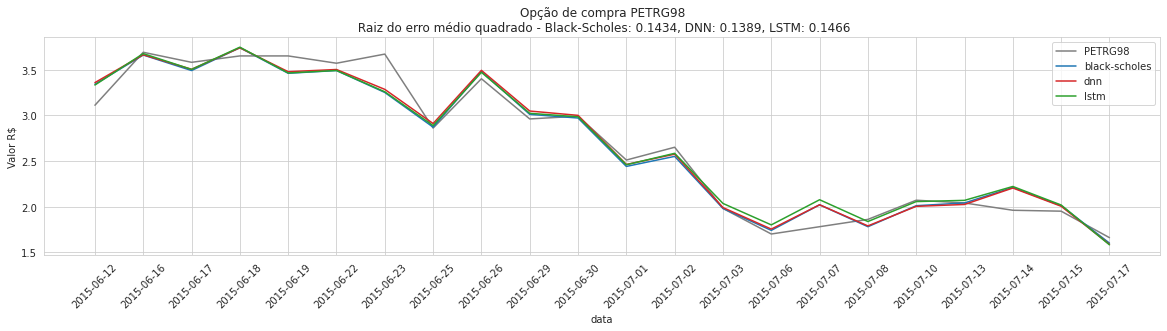

In [ ]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'compra', 'PETRG98', '2015-07-20', 22)

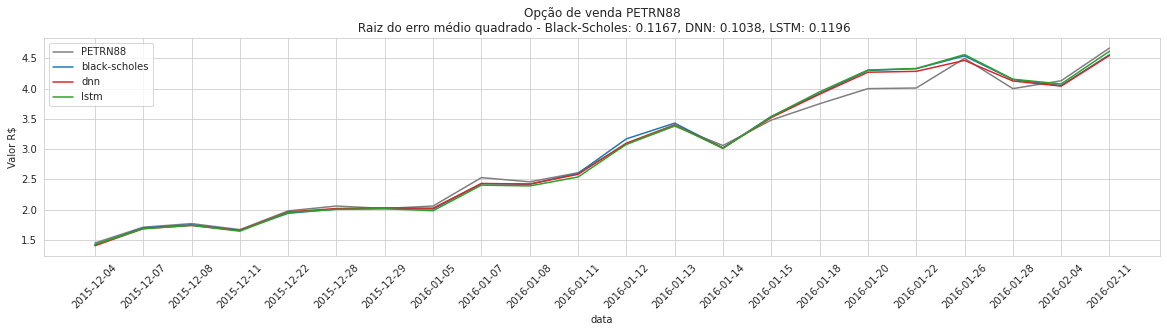

In [ ]:
# OPÇÕES DE VENDA (DNN)
plot(data, 'venda', 'PETRN88', '2016-02-15', 22)

## Opções ATM

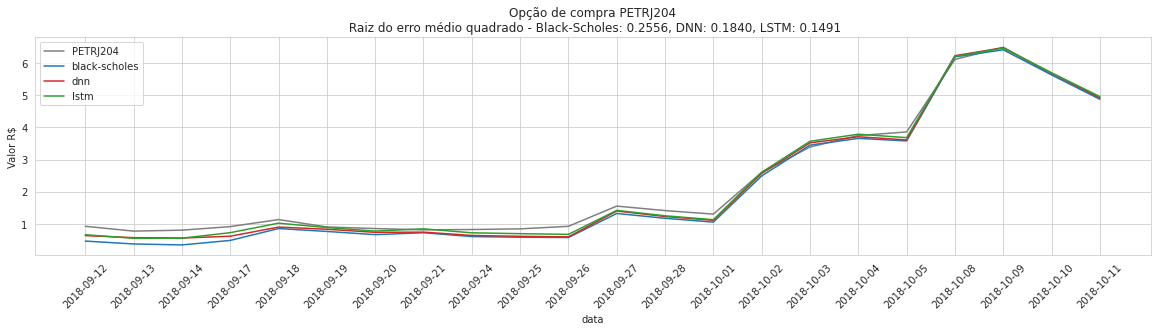

In [ ]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'compra', 'PETRJ204', '2018-10-15', 22)

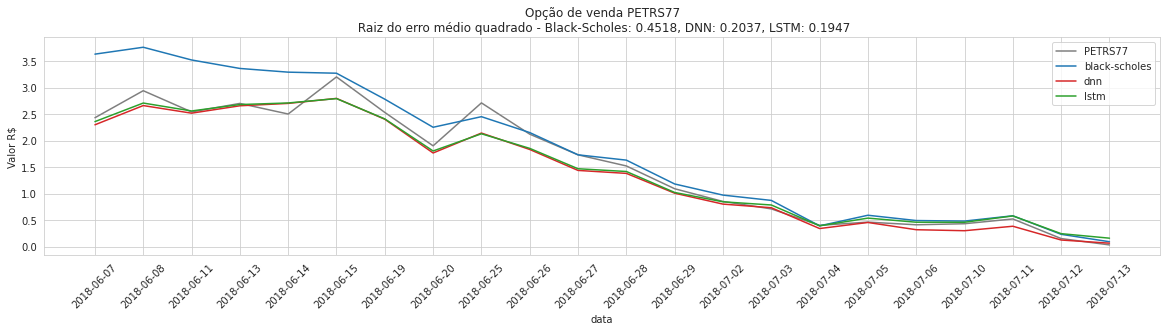

In [ ]:
# OPÇÕES DE VENDA (LSTM)
plot(data, 'venda', 'PETRS77', '2018-07-16', 22)

## Opções OTM

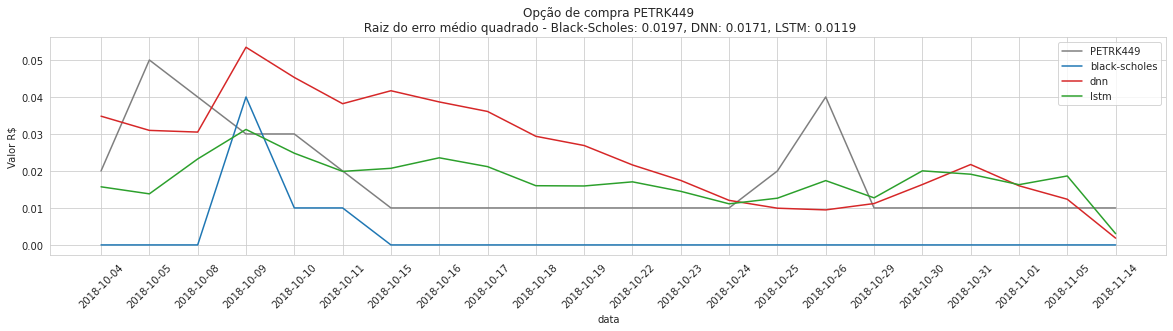

In [ ]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'compra', 'PETRK449', '2018-11-19', 22)

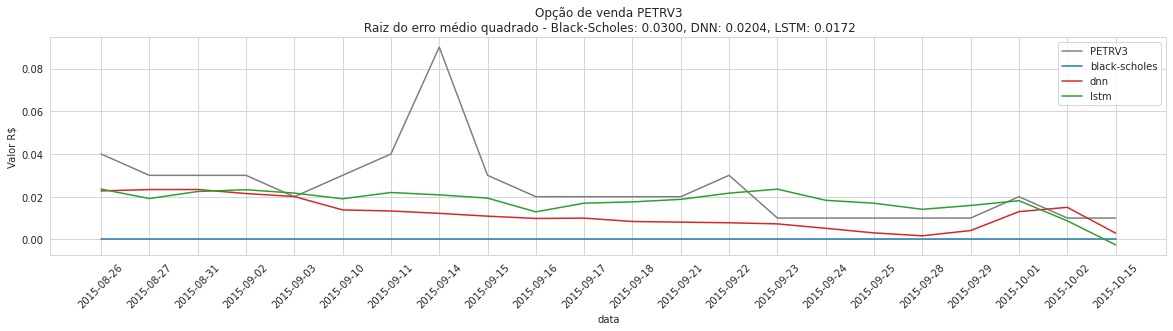

In [ ]:
# OPÇÕES DE VENDA (LSTM)
plot(data, 'venda', 'PETRV3', '2015-10-19', 22)

# Principais eventos

Foram selecionados dois períodos especificios para analise das métricas, esses períodos correspondem ao menores e maiores valores de volatilidade.

Para a escolha dos períodos foi calculada uma janela de volatilidade média dos últimos 22 dias do ativo subjacente a opção, ou seja, serão selecionados os 22 dias onde a volatilidade média foi a maior e menor do período.

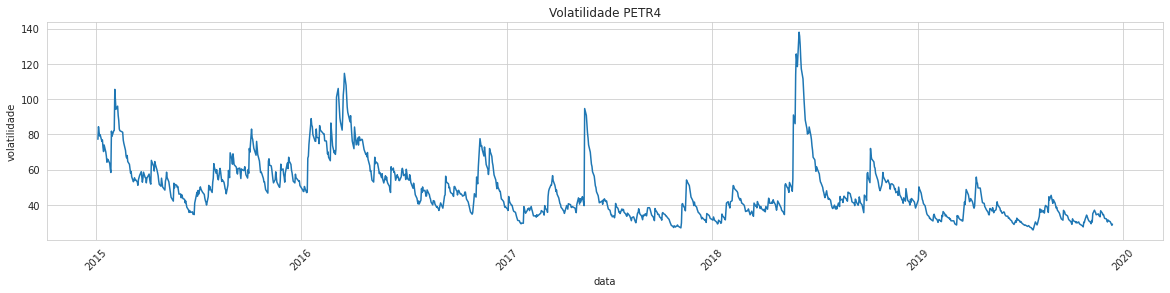

In [147]:
#@title Carregar dados de volatilidade
vol = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
vol = vol[['volatilidade']].drop_duplicates()

# Plot
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(pd.to_datetime(vol.index), vol['volatilidade'].values * 100)
axs.set(ylabel='volatilidade')
axs.set(xlabel='data')
axs.set_title('Volatilidade PETR4')
axs.tick_params(axis='x', labelrotation=45)
plt.show()

Os intervalo com menor volatilidade está entre o período de '2019-07-02' a '2019-09-03' com a volatilidade mínima em 28, o período de maior volatilidade está entre '2018-05-24' a '2018-07-27' com o máximo de 101.

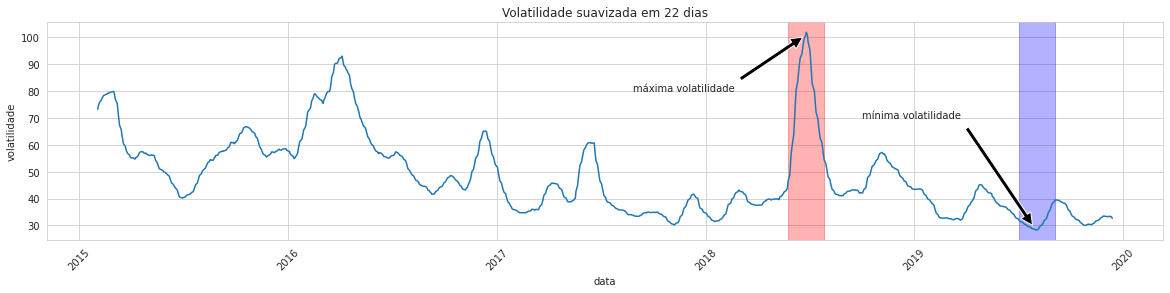

In [176]:
#@title

# Calculate rolling window
vol_avg = vol.rolling(22).mean().dropna()

# Plot
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(pd.to_datetime(vol_avg.index), vol_avg['volatilidade'].values * 100)
axs.set(ylabel='volatilidade')
axs.set(xlabel='data')
axs.set_title('Volatilidade suavizada em 22 dias')
axs.axvspan(date2num(pd.to_datetime('2019-07-02')),date2num(pd.to_datetime('2019-09-03')), alpha=0.3, color='blue')
axs.axvspan(date2num(pd.to_datetime('2018-05-24')),date2num(pd.to_datetime('2018-07-27')), alpha=0.3, color='red')

axs.annotate(
    'mínima volatilidade', 
    xy=(date2num(pd.to_datetime('2019-08-02')), 28), 
    xytext=(date2num(pd.to_datetime('2018-10-02')), 70),
    arrowprops=dict(facecolor='black', shrink=0.05),
    )

axs.annotate(
    'máxima volatilidade', 
    xy=(date2num(pd.to_datetime('2018-06-26')), 101), 
    xytext=(date2num(pd.to_datetime('2017-08-26')), 80),
    arrowprops=dict(facecolor='black', shrink=0.05),
    )

axs.tick_params(axis='x', labelrotation=45)
plt.show()

## Periodos de mínima e máxima volatilidade

In [206]:
#@title
def metric(data, min_range, max_range):

    # Instantiate
    bs, dnn, lstm = [], [], []

    # Loop over the dataframes
    for start, end in [min_range, max_range]:

        # Calculate metrics
        bs.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'black_scholes'],
                squared=False
                )
            )
        
        dnn.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'dnn'],
                squared=False
                )
            )
        
        lstm.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'lstm'],
                squared=False
                )
            )

    return pd.DataFrame({'black_scholes': bs, 'dnn': dnn, 'lstm': lstm}, index=['min', 'max'])

In [209]:
#@title
metric(data, ('2019-07-02', '2019-09-03'), ('2018-05-24', '2018-07-27'))

,black_scholes,dnn,lstm
min,0.286872,0.244068,0.239781
max,0.778358,0.248945,0.251823


## Resultados entre os anos

In [198]:
#@title
def metric(data, dates_range):

    # Instantiate
    bs, dnn, lstm = [], [], []

    # Loop over the dataframes
    for start, end in dates_range:

        # Calculate metrics
        bs.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'black_scholes'],
                squared=False
                )
            )
        
        dnn.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'dnn'],
                squared=False
                )
            )
        
        lstm.append(
            mean_squared_error(
                data.loc[start:end, 'preco_opcao'],
                data.loc[start:end, 'lstm'],
                squared=False
                )
            )

    return pd.DataFrame({'black_scholes': bs, 'dnn': dnn, 'lstm': lstm}, index=['2015', '2016', '2017', '2018', '2019'])

In [200]:
#@title
years = metric(data,
       (('2015-01-01','2015-12-31'),
        ('2016-01-01','2016-12-31'),
        ('2017-01-01','2017-12-31'),
        ('2018-01-01','2018-12-31'),
        ('2019-01-01','2019-12-31'))
       )
years

,black_scholes,dnn,lstm
2015,0.184323,0.113043,0.112857
2016,0.210517,0.161707,0.162444
2017,0.214961,0.123451,0.114299
2018,0.449729,0.250696,0.228992
2019,0.378995,0.334266,0.335801


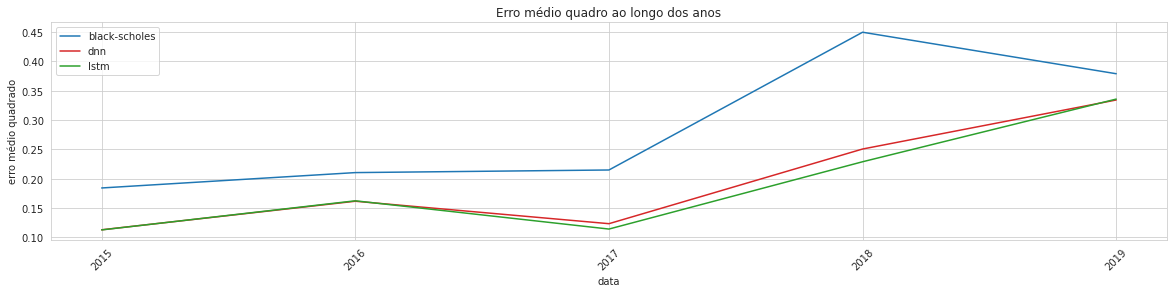

In [204]:
#@title
# Plot
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(years.index, years['black_scholes'], 'tab:blue', label='black-scholes')
axs.plot(years.index, years['dnn'], 'tab:red', label='dnn')
axs.plot(years.index, years['lstm'], 'tab:green', label='lstm')
axs.set_title(f'Erro médio quadro ao longo dos anos')
axs.set(ylabel='erro médio quadrado')
axs.set(xlabel='data')
axs.tick_params(axis='x', labelrotation=45)
axs.legend()
plt.show()

# Conclusão

Como analise final, a rede LSTM obteve melhores resultados na maioria dos casos, perdendo somente nas opções ITM para a rede DNN.